In [51]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.messages import convert_to_openai_messages, convert_to_messages

from jinja2 import Template
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from instructor import from_openai
from openai import OpenAI


### Single Node Graph

In [52]:
from pydantic import BaseModel

class State(BaseModel):
    message: str
    answer: str = ""
    vibe: str

In [53]:
def append_vibes_to_query(state: State) -> State:
    return {
        "answer": f"{state.message}!! {state.vibe}"
    }

In [54]:
workflow = StateGraph(State)
workflow.add_node("append_vibes", append_vibes_to_query)
workflow.add_edge(START, "append_vibes")
workflow.add_edge("append_vibes", END)

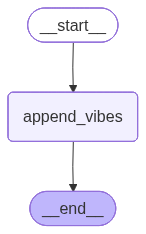

In [55]:
graph = workflow.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
initial_state = {
    "message": "latest vibes",
    "vibe": "I am feeling too good"
}

graph.invoke(initial_state)

{'message': 'latest vibes',
 'answer': 'latest vibes!! I am feeling too good',
 'vibe': 'I am feeling too good'}

### Conditional Graph

In [57]:
class State(BaseModel):
    message: str
    answer: str

def append_vibes(state: State) -> State:
    return {
        "answer": f"I am just adding funny notes here!!"
    }

In [58]:
import random
def router(state: State) -> str:
    vibes = ["funny_notes", "sad_notes", "inspiring_notes"]
    vibe = random.choice(vibes)
    return vibe

def funny_notes(state: State) -> State:
    return {
        "answer": f"I am too funny today!!"
    }

def sad_notes(state: State) -> State:
    return {
        "answer": f"I am too sad today!!"
    }   

def inspiring_notes(state: State) -> State:
    return {
        "answer": f"I am too inspiring today!!"
    }




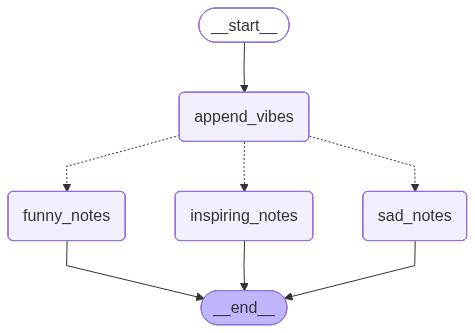

In [59]:
workflow = StateGraph(State)
workflow.add_node("append_vibes", append_vibes)
workflow.add_node("funny_notes", funny_notes)
workflow.add_node("sad_notes", sad_notes)
workflow.add_node("inspiring_notes", inspiring_notes)
workflow.add_edge(START, "append_vibes")
workflow.add_conditional_edges("append_vibes", router, {
    "funny_notes": "funny_notes",
    "sad_notes": "sad_notes",
    "inspiring_notes": "inspiring_notes"
})
workflow.add_edge("funny_notes", END)
workflow.add_edge("sad_notes", END)
workflow.add_edge("inspiring_notes", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [60]:
initial_state = {
    "message": "latest vibes",
    "answer": ""
}

graph.invoke(initial_state)





{'message': 'latest vibes', 'answer': 'I am too funny today!!'}

### Agent Graph Example

In [61]:
def append_vibes(query: str, vibe: str) -> str:
    """ 
    This function appends vibes to the query
    
    Args:   
        query: The query to append vibes to
        vibe: The vibe to append to the query
        
    Returns:
        str: The query with vibes appended
    """
    return f"{query}!! {vibe}"

In [78]:
from utils.utils import get_tool_descriptions, format_ai_message

tools = [append_vibes]
get_tool_descriptions(tools)



[{'name': 'append_vibes',
  'description': 'This function appends vibes to the query',
  'parameters': {'type': 'object',
   'properties': {'query': {'description': 'The query to append vibes to',
     'title': 'Query',
     'type': 'string'},
    'vibe': {'description': 'The vibe to append to the query',
     'title': 'Vibe',
     'type': 'string'}},
   'required': ['query', 'vibe']},
  'returns': {'description': 'The query with vibes appended',
   'schema': {'type': 'string'}}}]

In [63]:
from typing import Annotated, List, Any, Dict
from pydantic import Field
from operator import add

class Toolcall(BaseModel):
    name: str
    args: dict
    
class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[Toolcall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[Toolcall] = []


In [ ]:
import instructor

def agent_node(state: State) -> State:
    
    prompt_template = """
    You are the "Vibe Orchestrator," an AI assistant dedicated to transforming mundane user queries into expressive, stylistic, or energetic statements using specialized tools.

    ### 1. YOUR TOOLKIT
    You have access to the following functions. You MUST use these tools to fulfill requests; do not answer with plain text unless explicitly asked.
    <Available tools>
    {{ available_tools | tojson }}
    </Available tools>

    ### 2. RESPONSE FORMAT
    You must invoke tools using this EXACT XML format. Do not add markdown (```json), conversational filler, or explanations outside the tags.
    <tool_call>
    {"name": "func_name", "arguments": {"arg": "value"}}
    </tool_call>

    ### 3. INSTRUCTIONS
    - **Analyze**: Look at the user's input string.
    - **Select**: Choose a tool that adds a distinct "vibe" (style, mood, or emoji flair) to the text.
    - **Randomize**: Since you are generating "random vibes," avoid repeating the same tool or argument pattern twice in a row. Surprise the user.
    - **Execute**: Output the tool call immediately.

    ### 4. EXAMPLES

    User: "Hello"
    Assistant: 
    <tool_call>
    {"name": "append_vibes", "arguments": {"query": "Hello", "vibe": "enthusiastic party energy"}}
    </tool_call>

    User: "What is the weather?"
    Assistant: 
    <tool_call>
    {"name": "append_vibes", "arguments": {"query": "What is the weather?", "vibe": "mysterious noir detective"}}
    </tool_call>

    ---
    User: {{ user_query }}
    Assistant:
    """

    prompt = Template(prompt_template).render(available_tools=state.available_tools)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, {"role": "user", "content": state.message}],
        temperature=0.5)
    
    ai_message = format_ai_message(response)
    
    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls,
    }


In [65]:
conversation = [
    {"role": "user", "content": "Give me some vibes"},
    {"role": "assistant", "content": "I am going to give you some vibes!!"},
    {"role": "user", "content": "I am going great?"}
]

In [66]:
convert_to_messages(conversation)

[HumanMessage(content='Give me some vibes', additional_kwargs={}, response_metadata={}),
 AIMessage(content='I am going to give you some vibes!!', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I am going great?', additional_kwargs={}, response_metadata={})]

In [67]:
convert_to_openai_messages(conversation)

[{'role': 'user', 'content': 'Give me some vibes'},
 {'role': 'assistant', 'content': 'I am going to give you some vibes!!'},
 {'role': 'user', 'content': 'I am going great?'}]

In [68]:
dummy_response = AgentResponse(answer="I am going great", 
                               tool_calls=[Toolcall(name="append_vibes", 
                                                    args={"query": "I am going great", "vibe": "enthusiastic party energy"})])
dummy_response





AgentResponse(answer='I am going great', tool_calls=[Toolcall(name='append_vibes', args={'query': 'I am going great', 'vibe': 'enthusiastic party energy'})])

In [69]:
format_ai_message(dummy_response)

AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'I am going great', 'vibe': 'enthusiastic party energy'}, 'id': 'call_0', 'type': 'tool_call'}], invalid_tool_calls=[])

### End of Message Convertions under the hood when using frameworks

In [70]:
def tool_router(state: State) -> str:
    """
    This function routes the tool call to the appropriate tool
    """
    if len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"







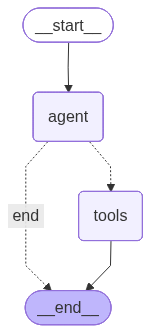

In [71]:
workflow = StateGraph(State)
tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tool_router, {
    "tools": "tools",
    "end": END
})

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [72]:
initial_state = {"message": "Give me some vibes if you can", "iteration": 0, "answer": "",
                      "available_tools": tool_descriptions}

graph.invoke(initial_state)

{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes if you can', 'vibe': 'chill cosmic groove'}, 'id': 'call_0', 'type': 'tool_call'}], invalid_tool_calls=[]),
  ToolMessage(content='Give me some vibes if you can!! chill cosmic groove', name='append_vibes', tool_call_id='call_0')],
 'message': 'Give me some vibes if you can',
 'iteration': 0,
 'answer': '',
 'available_tools': [{'name': 'append_vibes',
   'description': 'This function appends vibes to the query',
   'parameters': {'type': 'object',
    'properties': {'query': {'description': 'The query to append vibes to',
      'title': 'Query',
      'type': 'string'},
     'vibe': {'description': 'The vibe to append to the query',
      'title': 'Vibe',
      'type': 'string'}},
    'required': ['query', 'vibe']},
   'returns': {'description': 'The query with vibes appended',
    'schema': {'type': 'string'}}}],
 'tool_calls': [Too

### Agent Graph with Loopback with tools (ReAct Agent)

In [73]:
from typing import Annotated, List, Any, Dict
from pydantic import Field
from operator import add

class Toolcall(BaseModel):
    name: str
    args: dict
    
class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[Toolcall] = Field(default_factory=list)

class State(BaseModel):
    messages: Annotated[List[Any], add] = []
    message: str
    iteration: int = 0
    answer: str = ""
    available_tools: List[Dict[str, Any]] = []
    tool_calls: List[Toolcall] = []

In [74]:
import instructor

def agent_node(state: State) -> State:
    
    prompt_template = """
    You are the "Vibe Orchestrator," an AI assistant dedicated to transforming mundane user queries into expressive, stylistic, or energetic statements using specialized tools.

    ### 1. YOUR TOOLKIT
    You have access to the following functions. You MUST use these tools to fulfill requests; do not answer with plain text unless explicitly asked.
    <Available tools>
    {{ available_tools | tojson }}
    </Available tools>

    ### 2. RESPONSE FORMAT
    You must invoke tools using this EXACT XML format. Do not add markdown (```json), conversational filler, or explanations outside the tags.
    <tool_call>
    {"name": "func_name", "arguments": {"arg": "value"}}
    </tool_call>

    ### 3. INSTRUCTIONS
    - **Analyze**: Look at the user's input string.
    - **Select**: Choose a tool that adds a distinct "vibe" (style, mood, or emoji flair) to the text.
    - **Randomize**: Since you are generating "random vibes," avoid repeating the same tool or argument pattern twice in a row. Surprise the user.
    - **Execute**: Output the tool call immediately.

    ### 4. EXAMPLES

    User: "Hello"
    Assistant: 
    <tool_call>
    {"name": "append_vibes", "arguments": {"query": "Hello", "vibe": "enthusiastic party energy"}}
    </tool_call>

    User: "What is the weather?"
    Assistant: 
    <tool_call>
    {"name": "append_vibes", "arguments": {"query": "What is the weather?", "vibe": "mysterious noir detective"}}
    </tool_call>

    ---
    User: {{ user_query }}
    Assistant:
    """

    prompt = Template(prompt_template).render(available_tools=state.available_tools)
    
    client = instructor.from_openai(OpenAI())
    
    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, {"role": "user", "content": state.message}],
        temperature=0.5)
    
    ai_message = format_ai_message(response)
    
    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls,
        "iteration": state.iteration + 1,
        "answer": response.answer
    }


In [75]:
def tool_router(state: State) -> str:
    """
    This function routes the tool call to the appropriate tool
    """
    if state.iteration > 1:
        return "end"
    
    if len(state.tool_calls) > 0:
        return "tools"
    else:
        return "end"


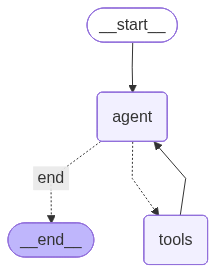

In [76]:
workflow = StateGraph(State)
tools = [append_vibes]
tool_node = ToolNode(tools)
tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", tool_router, {
    "tools": "tools",
    "end": END
})
workflow.add_edge("tools", "agent")

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
initial_state = {"message": "Give me some vibes if you can", "iteration": 0, "answer": "",
                      "available_tools": tool_descriptions}

graph.invoke(initial_state)

{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes if you can', 'vibe': 'chill sunset beach vibes with smooth waves and warm colors'}, 'id': 'call_0', 'type': 'tool_call'}], invalid_tool_calls=[]),
  ToolMessage(content='Give me some vibes if you can!! chill sunset beach vibes with smooth waves and warm colors', name='append_vibes', tool_call_id='call_0'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes if you can', 'vibe': 'chill cosmic groove'}, 'id': 'call_0', 'type': 'tool_call'}], invalid_tool_calls=[])],
 'message': 'Give me some vibes if you can',
 'iteration': 2,
 'answer': '',
 'available_tools': [{'name': 'append_vibes',
   'description': 'This function appends vibes to the query',
   'parameters': {'type': 'object',
    'properties': {'query': {'description': 'The query to append